In [1]:
# PROCESS THE BAILER-JONES NEAR ENCOUNTERS CATALOG:
# https://cdsarc.cds.unistra.fr/viz-bin/cat/J/ApJ/935/L9
#
#
# ZACK REEVES
# CREATED: 2024
#
# VERSIONS:
#  1.1  MAR 2024 CREATE JUPYTER NOTEBOOK

In [2]:
import pandas as pd
import numpy as np
import sys
import os
import collections

import astropy.units as u
import astropy.coordinates
from astropy.table import Table, join

from astroquery.vizier import Vizier
from astroquery.gaia import Gaia

sys.path.insert(0, '..')
from common import file_functions, calculations

from matplotlib import pyplot as plt, colors

In [3]:
# Define the metadata for the data set. 
metadata = {}

metadata['project'] = 'Digital Universe Atlas Gaia Subsets'
metadata['sub_project'] = 'Close encounters to the Sun'

metadata['catalog'] = 'Close encounters to the Sun in Gaia DR3 (Bailer-Jones, 2022)'
metadata['catalog_author'] = 'Bailer-Jones'
metadata['catalog_year'] = '2022'
metadata['catalog_doi'] = 'doi:10.1051/0004-6361/202039498'  #need to fix
metadata['catalog_bibcode'] = '2021A&A...649A...6G' #need to fix

metadata['prepared_by'] = 'Zack Reeves (AMNH)'
metadata['version'] = '1.1'

metadata['dir'] = metadata['sub_project'].replace(' ', '_').lower()
metadata['raw_data_dir'] = ''

metadata['data_group_title'] = 'Near Encounters to the Sun'
metadata['data_group_desc'] = 'Near Encounters to the Sun'
metadata['data_group_desc_long'] = '' #need to write

metadata['fileroot'] = 'near_encounters'
file_functions.generate_license_file(metadata)
file_functions.generate_asset_file(metadata)

In [4]:
#reading in the catalogue
catalog = Vizier(catalog='J/ApJ/935/L9/table12', columns=['**'], row_limit=-1).query_constraints()
catalog[0]

recno,Flag,Seq,GaiaDR3,tphmed,tph5,tph95,dphmed,dph5,dph95,vphmed,vph5,vph95,Plx,e_Plx,PM,e_PM,RV,e_RV,rv_vt,Gmag,BP-RP,GMAG,RUWE,Solved,IPDfmp,RVS_N,o_RV,GLON,GLAT,Simbad,_RA.icrs,_DE.icrs
,,,,kyr,kyr,kyr,pc,pc,pc,km / s,km / s,km / s,mas,mas,mas / yr,mas / yr,km / s,km / s,,mag,mag,mag,,,,,,deg,deg,,deg,deg
int32,str3,int16,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,int16,float64,float64,float64,float64,int16,int16,float64,int16,float64,float64,str6,float64,float64
1,,1,4270814637616488064,1292.1,1257.1,1334.1,0.0636,0.0595,0.0678,14.43,13.98,14.83,52.433,0.017,0.428,0.021,-14.42,0.26,373,9.0630880,1.69372460,7.65959119436154,0.91285527,31,0,132.5779300,6,27.58082464307,6.13044513408,Simbad,274.96183809552,-1.93861094464
2,,2,510911618569239040,-2761.0,-2797.9,-2719.5,0.0641,0.0191,0.1171,26.77,26.44,27.15,13.236,0.032,0.144,0.023,26.76,0.21,517,8.8913190,0.76438330,4.49613702909893,2.01492600,31,0,188.8394600,18,126.35232283848,-0.79589376133,Simbad,20.13165681910,61.88252018577
3,d,3,5544743925212648320,29.2,28.2,30.4,0.1172,0.1135,0.1218,374.30,359.71,387.07,89.545,0.015,71.697,0.018,-373.74,8.18,98,14.3463080,0.68349360,14.10557883436490,1.03885290,31,0,6.2259560,16,253.12281091169,-0.79831954224,Simbad,123.11242065286,-35.49549871571
4,,4,213090546082530816,8316.4,7874.3,8873.6,0.2482,0.0716,0.4848,22.98,21.48,24.29,5.072,0.014,0.449,0.013,-23.47,0.82,56,12.0621170,0.99363330,5.57620054069361,1.04663180,31,0,38.7788850,25,160.61555218994,4.85171776544,Simbad,77.83893301907,47.76355101445
5,b,5,5571232118090082816,-1156.7,-1165.9,-1145.9,0.2601,0.2491,0.2695,82.56,81.91,83.30,10.244,0.009,0.471,0.011,82.48,0.42,379,11.7818800,1.49293330,6.83210707658509,0.92668910,31,26,31.2480100,9,249.97666255354,-25.12032678659,Simbad,92.73103563880,-42.76760945426
6,,6,5469802896279029504,11118.7,10280.8,12221.8,0.3483,0.2487,0.7277,3.16,2.90,3.39,29.399,0.016,2.388,0.017,-2.66,0.17,7,10.0763570,1.62006000,7.41587625017846,1.29775880,31,0,119.3018500,13,270.54048828644,28.69009058190,Simbad,161.29825559238,-26.12585043867
7,,7,3372104035275483392,1706.1,1518.4,1981.6,0.3603,0.2952,0.4412,47.65,40.98,53.49,12.032,0.035,0.709,0.040,-47.45,3.74,170,15.3076030,2.57186600,10.69964832006420,0.96581580,31,0,3.7097740,8,193.63472146147,3.51275108579,Simbad,97.04831160984,18.75357940164
8,d,8,3207963476278403200,-513.9,-528.9,-498.5,0.3620,0.3078,0.4179,515.14,506.06,525.50,3.694,0.048,0.810,0.039,515.46,5.81,496,14.8894010,2.63412950,7.69206662385014,1.07850600,95,28,4.2067556,9,207.53118686822,-25.14150339684,Simbad,78.03144470178,-6.77071774137


In [5]:
#reducing data down to the necessary columns
data = catalog[0][['GaiaDR3', 'tphmed', 'dphmed', 'vphmed', 'Plx', 'e_Plx', 'RV', 'Gmag', 'GMAG', 'GLON', 'GLAT']]

In [6]:
#Query Gaia ESA ADQL server using Gaia EDR3 IDs to obtain proper motion and RA/DEC to calculate uvw

#log in to Gaia Server - Can change to different credentials file for a different user
Gaia.login(credentials_file='../common/gaia_credentials.txt')

#grab username from file
file = open('../common/gaia_credentials.txt', 'r')
username = file.readline().strip()

#Upload table (table name will be forced to lowercase)
job = Gaia.upload_table(upload_resource=data[['GaiaDR3']], table_name="near_encounters", format="csv")

#Query Gaia DR3 source for parallaxes
#Potentially want Bailer Jones distances pending figuring out the parallax error issue
job = Gaia.launch_job_async("select a.GaiaDR3, b.ra, b.dec, b.pmra, b.pmdec, bp_g "
                            "from user_"+username+".near_encounters a left join gaiadr3.gaia_source b on a.GaiaDR3 = b.source_id ",
                            dump_to_file=False)

#put the resulting table into a dataframe and drop the unnecessary index column
data = join(data, job.get_results(), keys='GaiaDR3', join_type='left')
# data.remove_column('xhip_main_oid')
#Deleting table and job from Gaia ESA server so we don't clog the memory
Gaia.delete_user_table('near_encounters')
Gaia.remove_jobs(job.jobid)

Gaia.logout()

INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
Sending pytable.
Uploaded table 'near_encounters'.
INFO: Query finished. [astroquery.utils.tap.core]
Table 'near_encounters' deleted.
Removed jobs: '1762204595010O'.
INFO: Gaia TAP server logout OK [astroquery.gaia.core]
INFO: Gaia data server logout OK [astroquery.gaia.core]


In [7]:
data

GaiaDR3,tphmed,dphmed,vphmed,Plx,e_Plx,RV,Gmag,GMAG,GLON,GLAT,ra,dec,pmra,pmdec,bp_g
,kyr,pc,km / s,mas,mas,km / s,mag,mag,deg,deg,deg,deg,mas / yr,mas / yr,mag
int64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32
213090546082530816,8316.4,0.2482,22.98,5.072,0.014,-23.47,12.0621170,5.57620054069361,160.61555218994,4.85171776544,77.83893167087938,47.763553049882645,0.16587197548712088,0.4176529570702126,0.41483498
398496965625177216,467.2,0.7280,151.90,13.780,0.038,-151.36,15.4469030,11.13513634677770,127.91560069737,-14.93150767306,20.01900262146951,47.662932194043655,-2.8174090607918645,-3.042727145758387,1.623846
418338821185634048,3098.1,0.9737,24.24,13.036,0.043,-24.01,14.7630510,10.33059474596080,121.70761581351,-7.52163549710,10.72542940722463,55.329821190695284,0.34725148630665087,-0.874112797966536,1.6328154
510911618569239040,-2761.0,0.0641,26.77,13.236,0.032,26.76,8.8913190,4.49613702909893,126.35232283848,-0.79589376133,20.131652206655247,61.882521645503466,0.1441100950163912,0.009536279528663762,0.29331017
775766686745320960,-305.3,0.8633,394.31,8.143,0.592,394.66,15.9094150,10.44882150881190,183.26495053035,61.79661517396,161.64425758064007,37.59181657550111,3.393809191863159,2.285896456616913,1.5529661
899893234465049216,1122.2,0.8787,41.54,20.992,0.042,-41.11,14.9554040,11.56008591461730,180.07070529149,21.80807415381,110.23268055691338,38.15199999039882,2.6069333955335554,2.7609506774113166,1.526722
911145876981562496,3660.3,0.7485,31.19,8.607,0.094,-30.75,12.4792290,7.14999255559838,183.55200783181,35.01928308742,127.51198996040647,38.261132803450515,0.8138178765586955,-0.11189176314922761,0.69585896
929788371508812288,-364.1,0.4625,195.27,13.758,0.059,195.68,15.8339710,11.51721403377860,173.12420882032,31.67510268892,121.3709965904039,46.41437668268302,-2.042764880298999,3.2324141403546154,1.901804


In [8]:
#calculating distance in light years and parsecs
calculations.get_distance(data, parallax='Plx', use='parallax')

In [9]:
#calculating cartesian coordinates
#calculations.get_cartesian(data, ra='ra', dec='dec', pmra='pmra', pmde='pmdec', radial_velocity='RV', frame='icrs')
calculations.get_cartesian(data, glon='GLON', glat='GLAT', pmra='pmra', pmde='pmdec', radial_velocity='RV', frame='icrs')

In [10]:
data

GaiaDR3,tphmed,dphmed,vphmed,Plx,e_Plx,RV,Gmag,GMAG,GLON,GLAT,ra,dec,pmra,pmdec,bp_g,dist_pc,dist_ly,x,y,z,u,v,w,speed
,kyr,pc,km / s,mas,mas,km / s,mag,mag,deg,deg,deg,deg,mas / yr,mas / yr,mag,pc,lyr,pc,pc,pc,km / s,km / s,km / s,
int64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
213090546082530816,8316.4,0.2482,22.98,5.072,0.014,-23.47,12.0621170,5.57620054069361,160.61555218994,4.85171776544,77.83893167087938,47.763553049882645,0.16587197548712088,0.4176529570702126,0.41483498,197.160889,643.1,-185.317996,65.204211,16.675344,22.163167,-7.559714,-1.631570,23.473757
398496965625177216,467.2,0.7280,151.90,13.780,0.038,-151.36,15.4469030,11.13513634677770,127.91560069737,-14.93150767306,20.01900262146951,47.662932194043655,-2.8174090607918645,-3.042727145758387,1.623846,72.568939,236.7,-43.087898,55.317749,-18.698413,90.717225,-115.094665,37.887835,151.366723
418338821185634048,3098.1,0.9737,24.24,13.036,0.043,-24.01,14.7630510,10.33059474596080,121.70761581351,-7.52163549710,10.72542940722463,55.329821190695284,0.34725148630665087,-0.874112797966536,1.6328154,76.710648,250.2,-39.971037,64.699371,-10.041464,12.434528,-20.347134,2.823781,24.012436
510911618569239040,-2761.0,0.0641,26.77,13.236,0.032,26.76,8.8913190,4.49613702909893,126.35232283848,-0.79589376133,20.131652206655247,61.882521645503466,0.1441100950163912,0.009536279528663762,0.29331017,75.551521,246.4,-44.778768,60.842362,-1.049447,-15.901503,21.520016,-0.362501,26.760050
775766686745320960,-305.3,0.8633,394.31,8.143,0.592,394.66,15.9094150,10.44882150881190,183.26495053035,61.79661517396,161.64425758064007,37.59181657550111,3.393809191863159,2.285896456616913,1.5529661,122.804871,400.5,-57.943719,-3.305460,108.224931,-184.871833,-8.814017,348.578415,394.667192
899893234465049216,1122.2,0.8787,41.54,20.992,0.042,-41.11,14.9554040,11.56008591461730,180.07070529149,21.80807415381,110.23268055691338,38.15199999039882,2.6069333955335554,2.7609506774113166,1.526722,47.637196,155.4,-44.227933,-0.054584,17.697157,38.447133,0.457548,-14.573129,41.118943
911145876981562496,3660.3,0.7485,31.19,8.607,0.094,-30.75,12.4792290,7.14999255559838,183.55200783181,35.01928308742,127.51198996040647,38.261132803450515,0.8138178765586955,-0.11189176314922761,0.69585896,116.184502,378.9,-94.967548,-5.895006,66.672724,25.390761,1.444843,-17.291295,30.753328
929788371508812288,-364.1,0.4625,195.27,13.758,0.059,195.68,15.8339710,11.51721403377860,173.12420882032,31.67510268892,121.3709965904039,46.41437668268302,-2.042764880298999,3.2324141403546154,1.901804,72.684982,237.1,-61.412900,7.405443,38.167025,-165.479633,21.158133,102.280106,195.684428


In [11]:
#setting dcalc
#setting metadata for dcalc
#since we calculate distance only using parallax in this dataset, dcalc is always 2
data['dcalc'] = data.Column(data=[2]*len(data),
                            meta=collections.OrderedDict([('ucd', 'meta.dcalc')]),
                            description='Distance Indicator: 1 indicates a Bailer-Jones photogeometric distance; 2 indicates a Bailer-Jones geometric distance')

In [12]:
#calculating absolute magnitudes
#calculate absolute V mag based on apparent magnitude and distance
data['appmag'] = data.MaskedColumn(data=data['Gmag'],
                             unit=u.mag,
                             meta=collections.OrderedDict([('ucd', 'phot.mag;em.opt.G')]),
                             format='{:.6f}',
                             description='Apparent magnitude in Gaia G-band')
data['absmag'] = data.MaskedColumn(data=[data['appmag'][i]+5-5*np.log10(data['dist_pc'][i]) for i in range(len(data))],
                             unit=u.mag,
                             meta=collections.OrderedDict([('ucd', 'phot.magAbs;em.opt.G')]),
                             format='{:.6f}',
                             description='Absolute magnitude in Gaia G-band')

In [13]:
#calculate luminosity based on absolute magnitude
data['lum'] = [10**(1.89 - 0.4*data['absmag'][i]) for i in range(len(data))]
small_luminosities = np.where((data['lum']>0.0) & (data['lum']<0.001))[0]
data['lum'][small_luminosities] = [0.001]*len(small_luminosities)

data['lum'] = data.MaskedColumn(data=data['lum'],
                             unit=u.solLum,
                             meta=collections.OrderedDict([('ucd', 'phys.luminosity')]),
                             format='{:.6f}',
                             description='Stellar Luminosity')

(array([12.,  6.,  9.,  7.,  7.,  7.,  8.,  2.,  2.,  1.]),
 array([0.18293858, 0.40348139, 0.62402421, 0.844567  , 1.06510985,
        1.28565264, 1.50619543, 1.72673821, 1.94728112, 2.16782379,
        2.3883667 ]),
 <BarContainer object of 10 artists>)

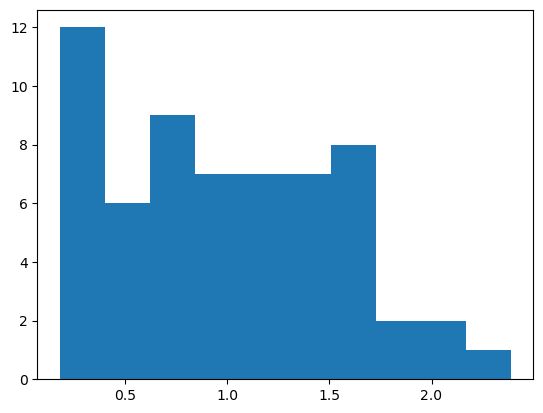

In [14]:
#setting color and visualizing
data['color'] = data.MaskedColumn(data=data['bp_g'],
                             unit=u.solLum,
                             meta=collections.OrderedDict([('ucd', 'phys.color')]),
                             format='{:.2f}',
                             description='Gaia BP-G color')
plt.hist(data['color'], bins=10)

<function matplotlib.pyplot.show(close=None, block=None)>

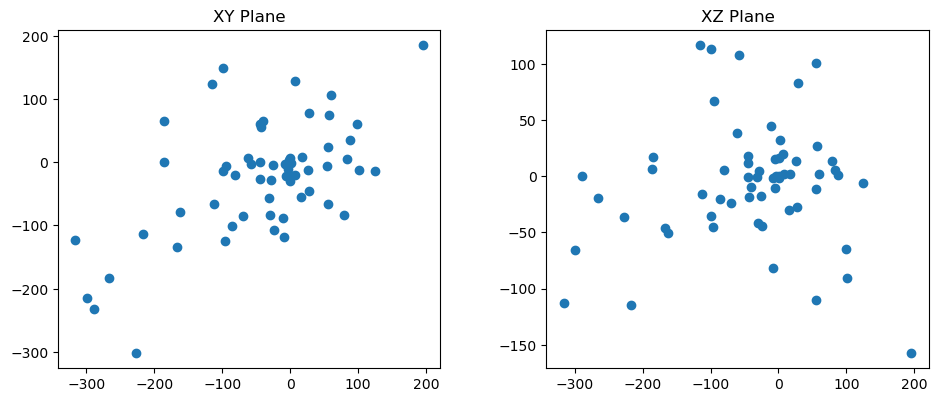

In [15]:
#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(data['x'], data['y'])
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(data['x'], data['z'])
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

In [16]:
data['error_over_parallax']=[data['e_Plx'][i]/data['Plx'][i] for i in range(len(data))]

In [17]:
len(data[data['error_over_parallax']>0.2])

0

In [18]:
#construct a speck comment column
data['speck_label'] = data.Column(data=['#__'+str(name) for name in data['GaiaDR3']], 
                                  meta=collections.OrderedDict([('ucd', 'meta.id')]),
                                  description='Gaia DR3 Source ID')

#construct a label column
data['label'] = ['GaiaDR3_'+ str(source) for source in data['GaiaDR3']]  #leaving for now in case we want to add other labels

In [19]:
#setting texture number column
data['texnum'] = data.Column(data=[1]*len(data), 
                                  meta=collections.OrderedDict([('ucd', 'meta.texnum')]),
                                  description='Texture Number')

In [20]:
#Getting the column metadata
columns = file_functions.get_metadata(data, columns=['x', 'y', 'z', 'color', 'lum', 'absmag', 'appmag', 'texnum', 'dist_ly', 'dcalc', 'u', 'v', 'w', 'speed', 'tphmed', 'dphmed', 'vphmed', 'speck_label'])
columns

,name,unit,datatype,width,precision,arraysize,ucd,description
0,x,pc,float64,,6,,pos.cartesian.x,x position (galactic cartesian coordinates) in...
1,y,pc,float64,,6,,pos.cartesian.y,Position (y coordinate) in parsecs
2,z,pc,float64,,6,,pos.cartesian.z,Position (z coordinate) in parsecs
3,color,solLum,float32,,2,,phys.color,Gaia BP-G color
4,lum,solLum,float64,,6,,phys.luminosity,Stellar Luminosity
5,absmag,mag,float64,,6,,phot.magAbs;em.opt.G,Absolute magnitude in Gaia G-band
6,appmag,mag,float64,,6,,phot.mag;em.opt.G,Apparent magnitude in Gaia G-band
7,texnum,,int32,,,,meta.texnum,Texture Number
8,dist_ly,lyr,float32,,1,,pos.distance,Distance from Sun (lyr)
9,dcalc,,int32,,,,meta.dcalc,Distance Indicator: 1 indicates a Bailer-Jones...


In [21]:
# Print the csv file using the to_csv function in file_functions
file_functions.to_csv(metadata, Table.to_pandas(data), columns)

In [22]:
# Print the speck file using the to_speck function in file_functions
file_functions.to_speck(metadata, Table.to_pandas(data), columns)

In [23]:
# Print the label file using the to_label function in file_functions
file_functions.to_label(metadata, Table.to_pandas(data))

In [24]:
from astropy.units import imperial

In [25]:
min(data['dphmed'].quantity).to(imperial.mile)

<Quantity 1.21943541e+12 mi>

In [26]:
data[data['dphmed']<0.07]

GaiaDR3,tphmed,dphmed,vphmed,Plx,e_Plx,RV,Gmag,GMAG,GLON,GLAT,ra,dec,pmra,pmdec,bp_g,dist_pc,dist_ly,x,y,z,u,v,w,speed,dcalc,appmag,absmag,lum,color,error_over_parallax,speck_label,label,texnum
,kyr,pc,km / s,mas,mas,km / s,mag,mag,deg,deg,deg,deg,mas / yr,mas / yr,mag,pc,lyr,pc,pc,pc,km / s,km / s,km / s,,,mag,mag,solLum,solLum,,,,
int64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float32,float32,str22,str27,int32
510911618569239040,-2761.0,0.0641,26.77,13.236,0.032,26.76,8.8913190,4.49613702909893,126.35232283848,-0.79589376133,20.131652206655247,61.882521645503466,0.1441100950163912,0.009536279528663762,0.29331017,75.551521,246.4,-44.778768,60.842362,-1.049447,-15.901503,21.520016,-0.362501,26.760050,2,8.891319,4.500103,1.230152,0.29,0.002417649,#__510911618569239040,GaiaDR3_510911618569239040,1
4270814637616488064,1292.1,0.0636,14.43,52.433,0.017,-14.42,9.0630880,7.65959119436154,27.58082464307,6.13044513408,274.96183629691126,-1.938612759804832,-0.4140637404226508,-0.10847507667730025,0.81336117,19.071959,62.2,16.807922,8.779810,2.036740,-12.698868,-6.662743,-1.511455,14.420052,2,9.063088,7.661112,0.066920,0.81,0.0003242233,#__4270814637616488064,GaiaDR3_4270814637616488064,1


In [27]:
data

GaiaDR3,tphmed,dphmed,vphmed,Plx,e_Plx,RV,Gmag,GMAG,GLON,GLAT,ra,dec,pmra,pmdec,bp_g,dist_pc,dist_ly,x,y,z,u,v,w,speed,dcalc,appmag,absmag,lum,color,error_over_parallax,speck_label,label,texnum
,kyr,pc,km / s,mas,mas,km / s,mag,mag,deg,deg,deg,deg,mas / yr,mas / yr,mag,pc,lyr,pc,pc,pc,km / s,km / s,km / s,,,mag,mag,solLum,solLum,,,,
int64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float32,float32,str22,str27,int32
213090546082530816,8316.4,0.2482,22.98,5.072,0.014,-23.47,12.0621170,5.57620054069361,160.61555218994,4.85171776544,77.83893167087938,47.763553049882645,0.16587197548712088,0.4176529570702126,0.41483498,197.160889,643.1,-185.317996,65.204211,16.675344,22.163167,-7.559714,-1.631570,23.473757,2,12.062117,5.588013,0.451642,0.41,0.0027602524,#__213090546082530816,GaiaDR3_213090546082530816,1
398496965625177216,467.2,0.7280,151.90,13.780,0.038,-151.36,15.4469030,11.13513634677770,127.91560069737,-14.93150767306,20.01900262146951,47.662932194043655,-2.8174090607918645,-3.042727145758387,1.623846,72.568939,236.7,-43.087898,55.317749,-18.698413,90.717225,-115.094665,37.887835,151.366723,2,15.446903,11.143149,0.002709,1.62,0.0027576196,#__398496965625177216,GaiaDR3_398496965625177216,1
418338821185634048,3098.1,0.9737,24.24,13.036,0.043,-24.01,14.7630510,10.33059474596080,121.70761581351,-7.52163549710,10.72542940722463,55.329821190695284,0.34725148630665087,-0.874112797966536,1.6328154,76.710648,250.2,-39.971037,64.699371,-10.041464,12.434528,-20.347134,2.823781,24.012436,2,14.763051,10.338773,0.005682,1.63,0.0032985578,#__418338821185634048,GaiaDR3_418338821185634048,1
510911618569239040,-2761.0,0.0641,26.77,13.236,0.032,26.76,8.8913190,4.49613702909893,126.35232283848,-0.79589376133,20.131652206655247,61.882521645503466,0.1441100950163912,0.009536279528663762,0.29331017,75.551521,246.4,-44.778768,60.842362,-1.049447,-15.901503,21.520016,-0.362501,26.760050,2,8.891319,4.500103,1.230152,0.29,0.002417649,#__510911618569239040,GaiaDR3_510911618569239040,1
775766686745320960,-305.3,0.8633,394.31,8.143,0.592,394.66,15.9094150,10.44882150881190,183.26495053035,61.79661517396,161.64425758064007,37.59181657550111,3.393809191863159,2.285896456616913,1.5529661,122.804871,400.5,-57.943719,-3.305460,108.224931,-184.871833,-8.814017,348.578415,394.667192,2,15.909415,10.463337,0.005066,1.55,0.072700486,#__775766686745320960,GaiaDR3_775766686745320960,1
899893234465049216,1122.2,0.8787,41.54,20.992,0.042,-41.11,14.9554040,11.56008591461730,180.07070529149,21.80807415381,110.23268055691338,38.15199999039882,2.6069333955335554,2.7609506774113166,1.526722,47.637196,155.4,-44.227933,-0.054584,17.697157,38.447133,0.457548,-14.573129,41.118943,2,14.955404,11.565673,0.001835,1.53,0.0020007621,#__899893234465049216,GaiaDR3_899893234465049216,1
911145876981562496,3660.3,0.7485,31.19,8.607,0.094,-30.75,12.4792290,7.14999255559838,183.55200783181,35.01928308742,127.51198996040647,38.261132803450515,0.8138178765586955,-0.11189176314922761,0.69585896,116.184502,378.9,-94.967548,-5.895006,66.672724,25.390761,1.444843,-17.291295,30.753328,2,12.479229,7.153488,0.106808,0.70,0.010921342,#__911145876981562496,GaiaDR3_911145876981562496,1
929788371508812288,-364.1,0.4625,195.27,13.758,0.059,195.68,15.8339710,11.51721403377860,173.12420882032,31.67510268892,121.3709965904039,46.41437668268302,-2.042764880298999,3.2324141403546154,1.901804,72.684982,237.1,-61.412900,7.405443,38.167025,-165.479633,21.158133,102.280106,195.684428,2,15.833971,11.526747,0.001902,1.90,0.004288414,#__929788371508812288,GaiaDR3_929788371508812288,1
